# Gas Level Classifier

In [ ]:
# data uploader
from google.colab import files

# ploting, dataframe, and numerical operation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from jcopml.plot import plot_classification_report, plot_confusion_matrix
# from plotfunc import 

# dataset splitting
from sklearn.model_selection import train_test_split

# training
!pip install jcopml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from sklearn.metrics import f1_score, classification_report, make_scorer

# feature engineering
from jcopml.feature_importance import mean_score_decrease as msd

In [ ]:
upload_file = files.upload()

## Data Loading

In [ ]:
df = pd.read_csv("gas_train.csv")

df = df.replace([-999.25], np.nan)

df.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Gas
0,4600.0,Poseidon-2,Jamieson Fm,66.4510,3.8376,3.6067,13.8882,2.5715,81.8708,NaN,0
1,4600.5,Poseidon-2,Jamieson Fm,54.4524,4.5844,4.2673,12.1851,2.5604,78.5466,NaN,0
2,4601.0,Poseidon-2,Jamieson Fm,51.3234,4.9751,4.4704,12.0860,2.5458,81.6343,NaN,0
3,4601.5,Poseidon-2,Jamieson Fm,49.2121,5.1362,4.6478,11.5609,2.5479,78.2709,NaN,0
4,4602.0,Poseidon-2,Jamieson Fm,68.4992,4.3777,4.0461,15.9469,2.5307,79.5989,NaN,0


## Data Statistics

- Target label well distributed

In [ ]:
df.describe()

,Depth,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Gas
count,2995.000000,2753.000000,2953.000000,2948.000000,2905.000000,2829.000000,2663.000000,2468.000000,2995.000000
mean,4962.672287,66.297613,43.498611,27.765264,20.972374,2.654081,68.878980,121.471750,0.069783
std,216.569096,35.844731,180.250196,74.263356,10.996101,0.119257,9.306656,22.403778,0.254823
min,4577.000000,5.377100,0.382200,0.106000,2.085300,1.525400,42.793000,69.261800,0.000000
25%,4775.500000,34.858300,4.396600,4.294575,11.536800,2.629200,62.438000,103.399550,0.000000
50%,4962.500000,65.694000,9.641000,9.460800,20.416900,2.674400,67.129600,117.314650,0.000000
75%,5149.750000,92.833300,25.361700,24.062525,27.419500,2.711300,75.134050,136.881475,0.000000
max,5351.000000,430.383900,1950.000000,1552.880400,82.672200,3.157100,179.561400,234.866500,1.000000


In [ ]:
df.Gas.value_counts()

0    2786
1     209
Name: Gas, dtype: int64

## Missing Values Checking

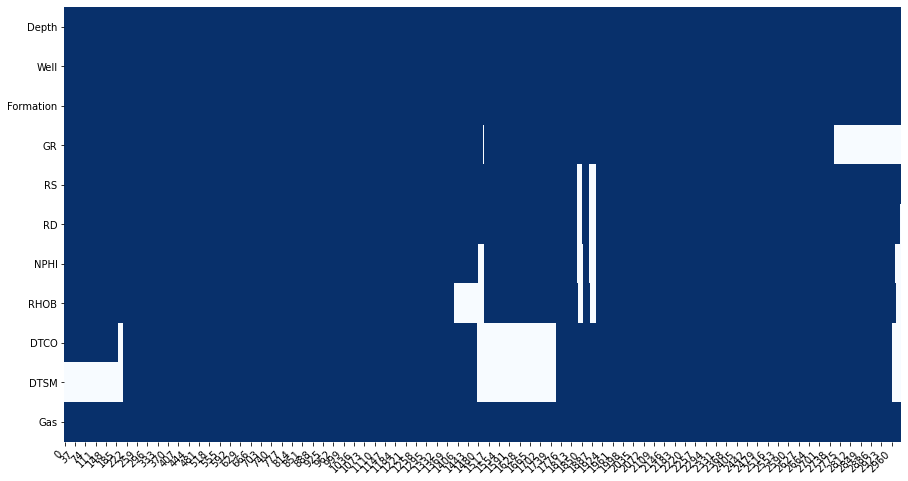

In [ ]:
plot_missing_value(df)

## Training Data Plotting

In [ ]:
def gasplot_data(df, well):
    df = df[df['Well'] == well]

    # gas color map
    # color order = [0, 1, 2, 3, ...]
    gas_colors = ['blue', 'yellow']
    cmap_gas = colors.ListedColormap(gas_colors)  # make color into colormap

    cluster = np.repeat(np.expand_dims(df.Gas, 1), 100, 1)

    # Set the top and bottom of depth
    top = df['Depth'].max()
    bottom = df['Depth'].min()

    # plotting
    fig, ax = plt.subplots(1, 5, figsize=(8, 12))

    # GR
    ax[0].plot(df.GR, df.Depth, c='g')
    ax[0].set_ylabel('Depth (m)')
    ax[0].set_xlabel('Gamma Ray (API)')
    ax[0].set_ylim(top, bottom)
    ax[0].set_xlim(df.GR.min(), df.GR.max())
    ax[0].grid()
    ax[0].xaxis.set_label_position('top')
    ax[0].xaxis.set_ticks_position('top')

    # RHOB
    ax[1].plot(df.RHOB, df.Depth, c='r')
    ax[1].set_xlabel('Density (g/cc)')
    ax[1].set_ylim(top, bottom)
    ax[1].set_xlim(df.RHOB.min(), df.RHOB.max())
    ax[1].grid()
    ax[1].xaxis.set_label_position('top')
    ax[1].xaxis.set_ticks_position('top')
    ax[1].set_yticklabels([])

     # NPHI
    ax[2].plot(df.NPHI, df.Depth, c='black')
    ax[2].set_xlabel('NPHI (.pu)')
    ax[2].set_ylim(top, bottom)
    ax[2].set_xlim(df.NPHI.min(), df.NPHI.max())
    ax[2].grid()
    ax[2].xaxis.set_label_position('top')
    ax[2].xaxis.set_ticks_position('top')
    ax[2].set_yticklabels([])

    # DTCO
    ax[3].plot(df.DTCO, df.Depth, c='blue')
    ax[3].set_xlabel('DTCO (us/f)')
    ax[3].set_ylim(top, bottom)
    ax[3].set_xlim(df.DTCO.min(), df.DTCO.max())
    ax[3].grid()
    ax[3].xaxis.set_label_position('top')
    ax[3].xaxis.set_ticks_position('top')
    ax[3].set_yticklabels([])

    # lithology
    im = ax[4].imshow(cluster, interpolation='none', aspect='auto',
                      cmap=cmap_gas, vmin=0, vmax=1)
    ax[4].set_xlabel('Gas Level')
    ax[4].xaxis.set_label_position('top')
    ax[4].xaxis.set_ticks_position('top')
    ax[4].set_xticks([])
    ax[4].set_yticklabels([])

    # color bar
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label((85 * ' ').join(['Low', 'Average']))
    cbar.set_ticks(range(0, 1));
    cbar.set_ticklabels('')

    # title
    fig.suptitle('%s Well' % df['Well'].iloc[0], fontsize=14)

    plt.show()

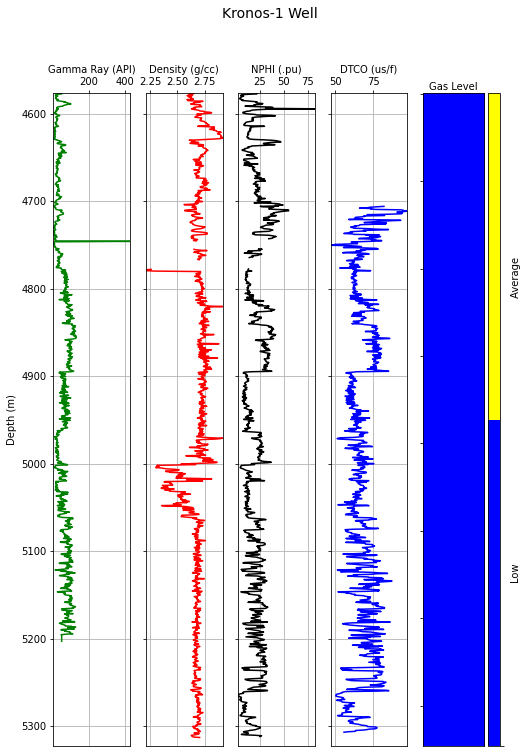

In [ ]:
gasplot_data(df, 'Kronos-1')

## Dataset Splitting

In [ ]:
df.columns

Index(['Depth', 'Well', 'Formation', 'GR', 'RS', 'RD', 'NPHI', 'RHOB', 'DTCO',
       'DTSM', 'Gas'],
      dtype='object')

In [ ]:
X = df.drop(columns=['Depth', 'Well', 'Formation', 'Gas'])
y = df.Gas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2396, 7), (599, 7), (2396,), (599,))

In [ ]:
X.columns

Index(['GR', 'RS', 'RD', 'NPHI', 'RHOB', 'DTCO', 'DTSM'], dtype='object')

## Training

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp, bayes_search_params as bsp

In [ ]:
X_train.columns

Index(['GR', 'RS', 'RD', 'NPHI', 'RHOB', 'DTCO', 'DTSM'], dtype='object')

In [ ]:
gsp.knn_params

{'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'algo__p': [1, 1.5, 2],
 'algo__weights': ['uniform', 'distance']}

In [ ]:
# f1 scoring
f1 = make_scorer(f1_score, average = 'average')

In [ ]:
preprocessor = ColumnTransformer([
                                  ('numeric', num_pipe(scaling = 'standard'), ['GR', 'RS', 'RD', 'NPHI', 'RHOB', 'DTCO', 'DTSM']),
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv= 5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print('')                      
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.0s



{'algo__n_neighbors': 5, 'algo__p': 1, 'algo__weights': 'distance'}
1.0 0.9795494084899096 0.986644407345576


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:   13.5s finished


### Tuning Report

In [ ]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__n_neighbors,param_algo__p,param_algo__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
13,0.008703,0.000433,0.015021,0.000614,5,1,distance,"{'algo__n_neighbors': 5, 'algo__p': 1, 'algo__...",0.979167,0.974948,0.983299,0.981211,0.979123,0.979549,0.002768,1
25,0.008150,0.000108,0.016399,0.000176,9,1,distance,"{'algo__n_neighbors': 9, 'algo__p': 1, 'algo__...",0.979167,0.974948,0.979123,0.983299,0.981211,0.979549,0.002768,1
19,0.008288,0.000308,0.016665,0.001854,7,1,distance,"{'algo__n_neighbors': 7, 'algo__p': 1, 'algo__...",0.981250,0.974948,0.981211,0.981211,0.979123,0.979549,0.002440,3
37,0.008109,0.000060,0.017876,0.000151,13,1,distance,"{'algo__n_neighbors': 13, 'algo__p': 1, 'algo_...",0.979167,0.974948,0.981211,0.981211,0.979123,0.979132,0.002287,4
49,0.008128,0.000092,0.019354,0.000667,17,1,distance,"{'algo__n_neighbors': 17, 'algo__p': 1, 'algo_...",0.981250,0.974948,0.979123,0.981211,0.979123,0.979131,0.002294,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.008925,0.000617,0.308155,0.008026,25,1.5,uniform,"{'algo__n_neighbors': 25, 'algo__p': 1.5, 'alg...",0.977083,0.970772,0.970772,0.972860,0.966597,0.971617,0.003407,82
5,0.008717,0.000789,0.008209,0.000270,1,2,distance,"{'algo__n_neighbors': 1, 'algo__p': 2, 'algo__...",0.975000,0.977035,0.956159,0.972860,0.974948,0.971200,0.007636,87
4,0.009324,0.002001,0.022510,0.000194,1,2,uniform,"{'algo__n_neighbors': 1, 'algo__p': 2, 'algo__...",0.975000,0.977035,0.956159,0.972860,0.974948,0.971200,0.007636,87
82,0.008791,0.000287,0.032373,0.001055,27,2,uniform,"{'algo__n_neighbors': 27, 'algo__p': 2, 'algo_...",0.977083,0.968685,0.970772,0.972860,0.966597,0.971200,0.003607,89


## Feature Engineering

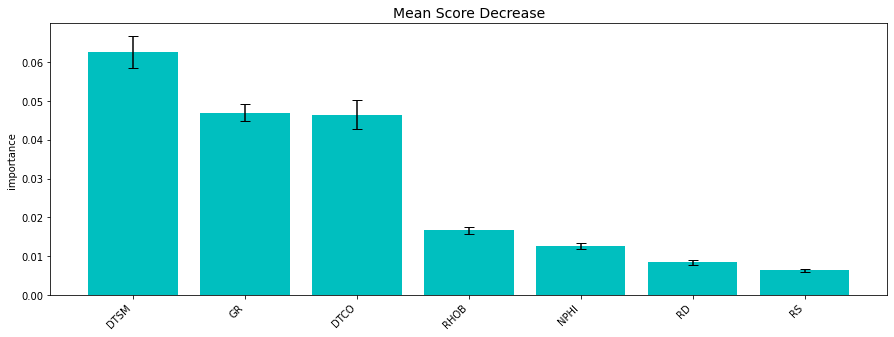

In [ ]:
df_fe = msd(X_train, y_train, model, plot = True, topk=7)

## Fine Tuning

In [ ]:
preprocessor = ColumnTransformer([
                                  ('numeric', num_pipe(scaling = 'standard'), ['GR', 'DTCO', 'DTSM']),
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv= 5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print('')                      
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.9s



{'algo__n_neighbors': 17, 'algo__p': 1, 'algo__weights': 'distance'}
1.0 0.9766266527487822 0.9833055091819699


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:    4.5s finished


## Prediction

### Predict Training Data

In [ ]:
df['Gas_pred'] = model.predict(X)

df.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Gas,Gas_pred
0,4600.0,Poseidon-2,Jamieson Fm,66.4510,3.8376,3.6067,13.8882,2.5715,81.8708,NaN,0,0
1,4600.5,Poseidon-2,Jamieson Fm,54.4524,4.5844,4.2673,12.1851,2.5604,78.5466,NaN,0,0
2,4601.0,Poseidon-2,Jamieson Fm,51.3234,4.9751,4.4704,12.0860,2.5458,81.6343,NaN,0,0
3,4601.5,Poseidon-2,Jamieson Fm,49.2121,5.1362,4.6478,11.5609,2.5479,78.2709,NaN,0,0
4,4602.0,Poseidon-2,Jamieson Fm,68.4992,4.3777,4.0461,15.9469,2.5307,79.5989,NaN,0,0


In [ ]:
def gasplot_val(df, well):
    df = df[df['Well'] == well]

    # gas color map
    gas_colors = ['blue', 'yellow']
    cmap_gas = colors.ListedColormap(gas_colors)  # make color into colormap

    cluster1 = np.repeat(np.expand_dims(df.Gas, 1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(df.Gas_pred, 1), 100, 1)

    # Set the top and bottom of depth
    top = df['Depth'].max()
    bottom = df['Depth'].min()

    # plotting
    fig, ax = plt.subplots(1, 6, figsize=(12, 12))

    # GR
    ax[0].plot(df.GR, df.Depth, c='g')
    ax[0].set_ylabel('Depth (m)')
    ax[0].set_xlabel('Gamma Ray (API)')
    ax[0].set_ylim(top, bottom)
    ax[0].set_xlim(df.GR.min(), df.GR.max())
    ax[0].grid()
    ax[0].xaxis.set_label_position('top')
    ax[0].xaxis.set_ticks_position('top')

    # RHOB
    ax[1].plot(df.RHOB, df.Depth, c='r')
    ax[1].set_xlabel('Density (g/cc)')
    ax[1].set_ylim(top, bottom)
    ax[1].set_xlim(df.RHOB.min(), df.RHOB.max())
    ax[1].grid()
    ax[1].xaxis.set_label_position('top')
    ax[1].xaxis.set_ticks_position('top')
    ax[1].set_yticklabels([])

    # NPHI
    ax[2].plot(df.NPHI, df.Depth, c='black')
    ax[2].set_xlabel('NPHI (.pu)')
    ax[2].set_ylim(top, bottom)
    ax[2].set_xlim(df.NPHI.min(), df.NPHI.max())
    ax[2].grid()
    ax[2].xaxis.set_label_position('top')
    ax[2].xaxis.set_ticks_position('top')
    ax[2].set_yticklabels([])

    # DTCO
    ax[3].plot(df.DTCO, df.Depth, c='blue')
    ax[3].set_xlabel('DTCO (us/f)')
    ax[3].set_ylim(top, bottom)
    ax[3].set_xlim(df.DTCO.min(), df.DTCO.max())
    ax[3].grid()
    ax[3].xaxis.set_label_position('top')
    ax[3].xaxis.set_ticks_position('top')
    ax[3].set_yticklabels([])

    # actual gas level
    im = ax[4].imshow(cluster1, interpolation='none', aspect='auto',
                      cmap=cmap_gas, vmin=0, vmax=1)
    ax[4].set_xlabel('Actual Gas Level')
    ax[4].xaxis.set_label_position('top')
    ax[4].xaxis.set_ticks_position('top')
    ax[4].set_xticks([])
    ax[4].set_yticklabels([])

    # predicted gas level
    im = ax[5].imshow(cluster2, interpolation='none', aspect='auto',
                      cmap=cmap_gas, vmin=0, vmax=1)
    ax[5].set_xlabel('Predicted Gas Level')
    ax[5].xaxis.set_label_position('top')
    ax[5].xaxis.set_ticks_position('top')
    ax[5].set_xticks([])
    ax[5].set_yticklabels([])

    # color bar
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label((85 * ' ').join(['Low', 'Average']))
    cbar.set_ticks(range(0, 1));
    cbar.set_ticklabels('')

    # title
    fig.suptitle('%s Well' % df['Well'].iloc[0], fontsize=14)

    plt.show()

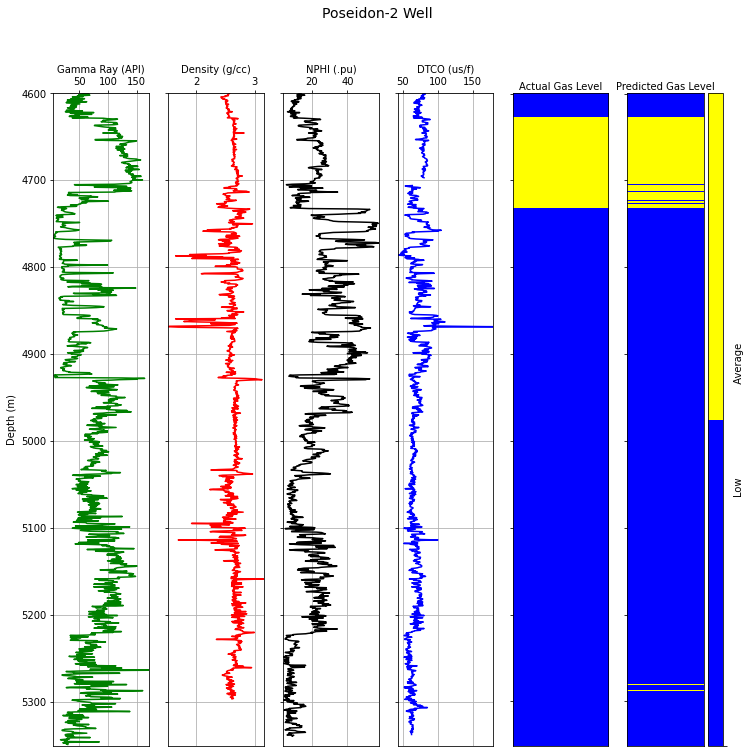

In [ ]:
gasplot_val(df, 'Poseidon-2')

In [ ]:
# classification report
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2229
           1       1.00      1.00      1.00       167

    accuracy                           1.00      2396
   macro avg       1.00      1.00      1.00      2396
weighted avg       1.00      1.00      1.00      2396


Test report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       557
           1       0.92      0.83      0.88        42

    accuracy                           0.98       599
   macro avg       0.95      0.91      0.93       599
weighted avg       0.98      0.98      0.98       599



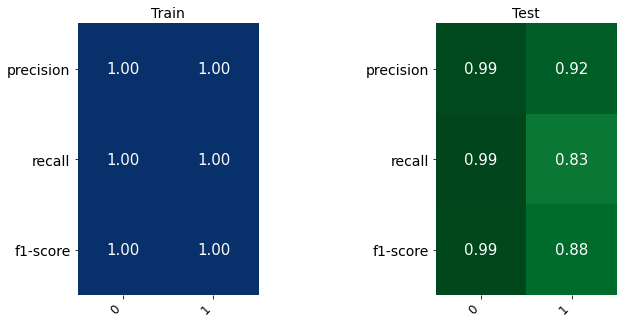

In [ ]:
plot_classification_report(X_train, y_train, X_test, y_test, model)

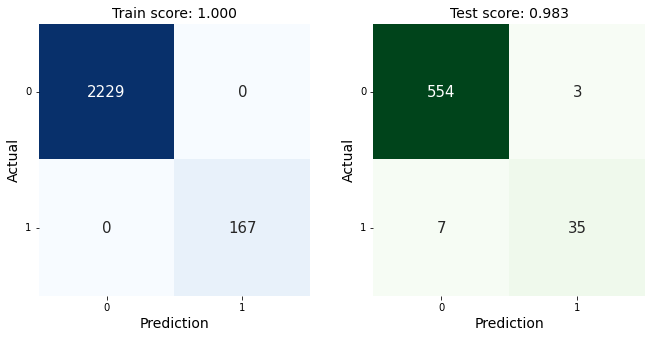

In [ ]:
# confussion matrix
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

### Predict Testing Data

In [ ]:
df_test = pd.read_csv('gas_test.csv')

df_test = df_test.replace([-999.25], np.nan)

df_test.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM
0,4610.0,Boreas-1,Echuca Shoals Fm,55.3259,1.4348,1.4170,12.04,2.6282,87.4786,NaN
1,4610.5,Boreas-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,NaN
2,4611.0,Boreas-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,NaN
3,4611.5,Boreas-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.6130,64.5839,NaN
4,4612.0,Boreas-1,Echuca Shoals Fm,86.1773,1.0648,1.0360,21.62,2.6041,69.4141,NaN


In [ ]:
df_test.columns

Index(['Depth', 'Well', 'Formation', 'GR', 'RS', 'RD', 'NPHI', 'RHOB', 'DTCO',
       'DTSM'],
      dtype='object')

In [ ]:
X_test = pd.DataFrame(df_test.drop(columns= ['Depth', 'Well', 'Formation']))

X_test.head()

,GR,RS,RD,NPHI,RHOB,DTCO,DTSM
0,55.3259,1.4348,1.4170,12.04,2.6282,87.4786,NaN
1,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,NaN
2,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,NaN
3,67.9765,1.3287,1.2345,20.01,2.6130,64.5839,NaN
4,86.1773,1.0648,1.0360,21.62,2.6041,69.4141,NaN


In [ ]:
df_test['Gas_pred'] = model.predict(X_test)

df_test.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Gas_pred
0,4610.0,Boreas-1,Echuca Shoals Fm,55.3259,1.4348,1.4170,12.04,2.6282,87.4786,NaN,0
1,4610.5,Boreas-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,NaN,0
2,4611.0,Boreas-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,NaN,0
3,4611.5,Boreas-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.6130,64.5839,NaN,0
4,4612.0,Boreas-1,Echuca Shoals Fm,86.1773,1.0648,1.0360,21.62,2.6041,69.4141,NaN,0


In [ ]:
def gasplot_test(df, well):
    df = df[df['Well'] == well]

    # gas color map
    gas_colors = ['blue', 'yellow']
    cmap_gas = colors.ListedColormap(gas_colors)  # make color into colormap

    cluster = np.repeat(np.expand_dims(df.Gas_pred, 1), 100, 1)

    # Set the top and bottom of depth
    top = df['Depth'].max()
    bottom = df['Depth'].min()

    # plotting
    fig, ax = plt.subplots(1, 5, figsize=(8, 12))

    # GR
    ax[0].plot(df.GR, df.Depth, c='g')
    ax[0].set_ylabel('Depth (m)')
    ax[0].set_xlabel('Gamma Ray (API)')
    ax[0].set_ylim(top, bottom)
    ax[0].set_xlim(df.GR.min(), df.GR.max())
    ax[0].grid()
    ax[0].xaxis.set_label_position('top')
    ax[0].xaxis.set_ticks_position('top')

    # RHOB
    ax[1].plot(df.RHOB, df.Depth, c='r')
    ax[1].set_xlabel('Density (g/cc)')
    ax[1].set_ylim(top, bottom)
    ax[1].set_xlim(df.RHOB.min(), df.RHOB.max())
    ax[1].grid()
    ax[1].xaxis.set_label_position('top')
    ax[1].xaxis.set_ticks_position('top')
    ax[1].set_yticklabels([])

    # NPHI
    ax[2].plot(df.NPHI, df.Depth, c='black')
    ax[2].set_xlabel('NPHI (.pu)')
    ax[2].set_ylim(top, bottom)
    ax[2].set_xlim(df.NPHI.min(), df.NPHI.max())
    ax[2].grid()
    ax[2].xaxis.set_label_position('top')
    ax[2].xaxis.set_ticks_position('top')
    ax[2].set_yticklabels([])

    # DTCO
    ax[3].plot(df.DTCO, df.Depth, c='blue')
    ax[3].set_xlabel('DTCO (us/f)')
    ax[3].set_ylim(top, bottom)
    ax[3].set_xlim(df.DTCO.min(), df.DTCO.max())
    ax[3].grid()
    ax[3].xaxis.set_label_position('top')
    ax[3].xaxis.set_ticks_position('top')
    ax[3].set_yticklabels([])

    # gas level
    im = ax[4].imshow(cluster, interpolation='none', aspect='auto',
                      cmap=cmap_gas, vmin=0, vmax=1)
    ax[4].set_xlabel('Gas Level')
    ax[4].xaxis.set_label_position('top')
    ax[4].xaxis.set_ticks_position('top')
    ax[4].set_xticks([])
    ax[4].set_yticklabels([])

    # color bar
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label((85 * ' ').join(['Low', 'Average']))
    cbar.set_ticks(range(0, 1));
    cbar.set_ticklabels('')

    # title
    fig.suptitle('%s Well' % df['Well'].iloc[0], fontsize=14)

    plt.show()

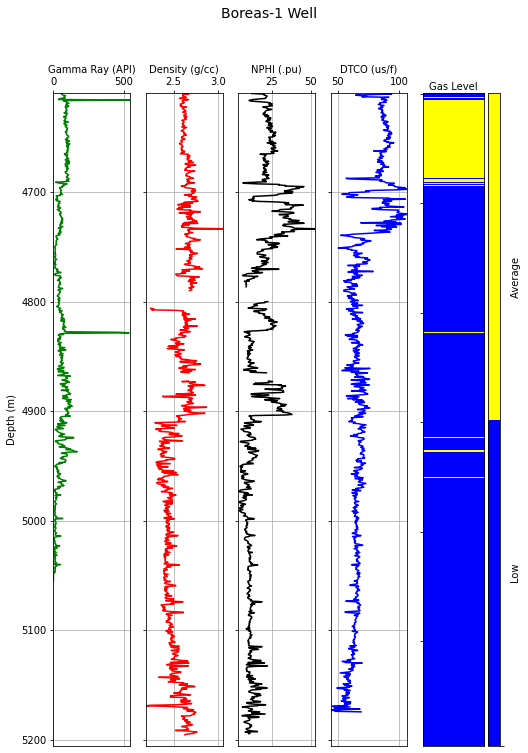

In [ ]:
gasplot_test(df_test, 'Boreas-1')

## Save ML Model

In [ ]:
save_model(model.best_estimator_, "__________.pkl")

Model is pickled as model/__________.pkl
